In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, os, re, random

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import layers, models

In [79]:
AUTO = tf.data.experimental.AUTOTUNE

In [80]:
IMAGE_SIZE = [331, 331]
BATCH_SIZE = 20

In [81]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']

In [82]:
GCS_PATH = r"C:\Users\91909\Desktop\DATA SCIENCE\DATA\Petals_to_Metal\tfrecords-jpeg-331x331"

In [83]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

In [84]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode the image
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]
    
    label = tf.cast(example['class'], tf.int32)
    
    return image, label

# Load the dataset from TFRecord files
def load_dataset(filenames, batch_size):
    # Create a dataset from the TFRecord files
    dataset = tf.data.TFRecordDataset(filenames)
    
    # Parse the dataset
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle, batch, and prefetch the dataset for performance
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

# Create datasets for training, validation, and testing
train_dataset = load_dataset(TRAINING_FILENAMES, BATCH_SIZE)
valid_dataset = load_dataset(VALIDATION_FILENAMES, BATCH_SIZE)
test_dataset = load_dataset(TEST_FILENAMES, BATCH_SIZE)

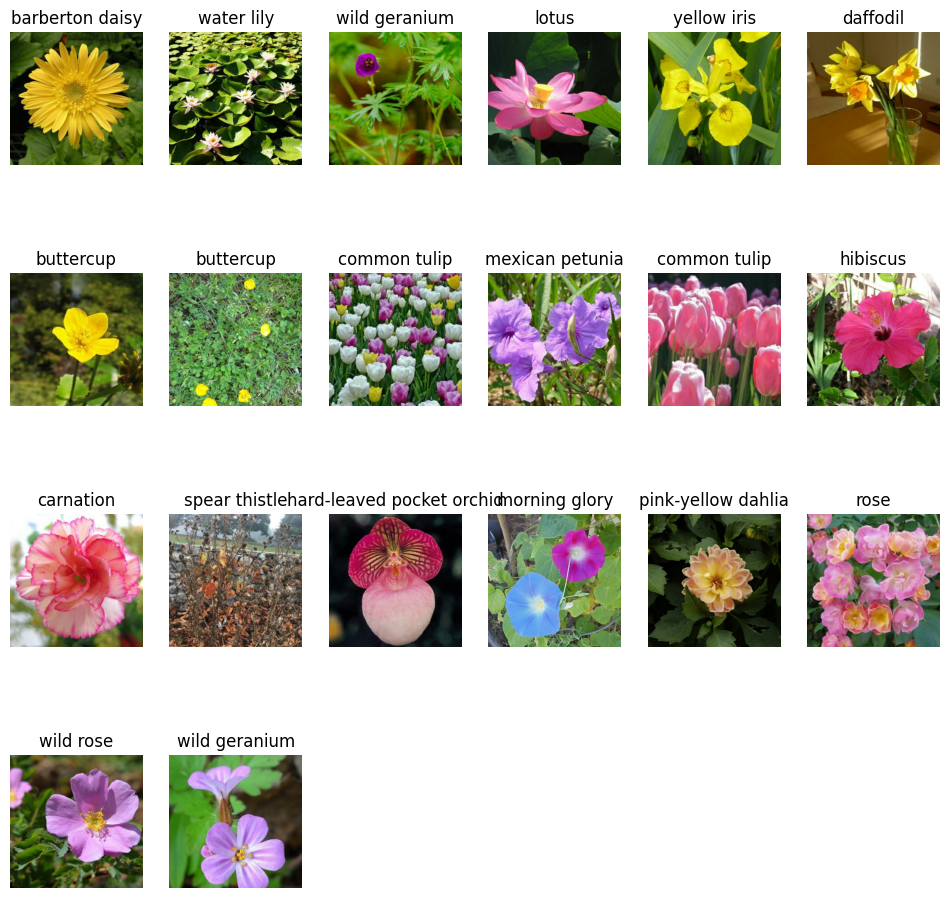

In [85]:
def plot_images(images, labels, CLASSES):
    plt.figure(figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(4, 6, i + 1)  # Adjust grid size as needed
        plt.imshow(images[i])
        plt.title(CLASSES[labels[i]])
        plt.axis('off')
    plt.show()

# Fetch a batch of images and labels
for image_batch, label_batch in train_dataset.take(1):
    # Convert to numpy arrays
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()

    # Define class names (adjust as needed)
    CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']

    # Plot images
    plot_images(image_batch, label_batch, CLASSES)

In [86]:
# Count the total number of images in the dataset
def count_dataset_images(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    count = sum(1 for _ in dataset)
    return count

# Count the number of training and test images
train_images = count_dataset_images(TRAINING_FILENAMES)
test_images = count_dataset_images(TEST_FILENAMES)

print(f'Total training images: {train_images}')
print(f'Total test images: {test_images}')


Total training images: 12753
Total test images: 7382


In [87]:
model = models.Sequential([
    layers.InputLayer(input_shape=(331, 331, 3)),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(CLASSES), activation='softmax')
])

In [88]:
# model = models.Sequential()

# model.add(BatchNormalization())
# model.add(Conv2D(filters=16, kernel_size=3, activation="relu", padding="valid", input_shape=(331, 331, 3)))
# model.add(MaxPooling2D())
# model.add(BatchNormalization())
# model.add(Conv2D(filters=32, kernel_size=3, activation="relu", padding="valid"))
# model.add(MaxPooling2D())
# model.add(BatchNormalization())
# model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding="valid"))
# model.add(MaxPooling2D())
# model.add(BatchNormalization())
# model.add(Conv2D(filters=128, kernel_size=3, activation="relu", padding="valid"))
# model.add(MaxPooling2D())
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(BatchNormalization())

# model.add(Dense(256, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation="sigmoid"))

In [89]:
model.build(input_shape=(331, 331, 3))

In [90]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 331, 331, 64)      1792      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 165, 165, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 165, 165, 128)     73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 82, 82, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 82, 82, 256)       295168    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 41, 41, 256)     

In [91]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [92]:
# history = model.fit(
#     train_dataset,
#     validation_data=valid_dataset,
#     epochs=20,
#     verbose=1
# )

In [93]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode and resize the image
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)  # Resize to (192, 192)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    
    label = tf.cast(example['class'], tf.int32)
    
    return image, label

In [94]:
# for image_batch, label_batch in train_dataset.take(1):
#     print(f"Image batch shape: {image_batch.shape}")
#     print(f"Label batch shape: {label_batch.shape}")

In [95]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)

In [98]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20
)

Epoch 1/20


ValueError: in user code:

    File "c:\Users\91909\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\91909\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\91909\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\91909\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\91909\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\91909\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 331, 331, 3), found shape=(None, None, 331, 331, 3)
